In [2]:
# Water faucet problem v1
# Water faucet problem with solvers and preconditioners
# Water faucet problem with solvers and preconditioners - Assembled *pendiente




In [1]:
# Water faucet problem v1
"""
WAVE PDE SYSTEM
Solution of convection-diffusion equation using CG and backward Crank Nicholson
PDE: 
IC : 
BC : DIRICHLET

https://fenicsproject.discourse.group/t/aritymismatch-for-crank-nicolson-method-on-mixed-function-space/781/3
"""

from __future__ import print_function
from IPython.display import clear_output
from fenics import *
import matplotlib.pyplot as plt
import numpy as np
import time

# Form compiler options
parameters ["form_compiler"]["optimize"]          = True
parameters ["form_compiler"]["cpp_optimize"]      = True
#parameters["form_compiler"]["representation"] = "quadrature"
parameters ["form_compiler"]["quadrature_degree"] = 2

parameters ["form_compiler"]["cpp_optimize"]      = True
ffc_options = {"optimize": True, \
               "eliminate_zeros": True, \
               "precompute_basis_const": True, \
               "precompute_ip_const": True}

# Define constants
#c     = 1.0
#mu    = 0.001
u1bc1  = 0.8 # alpha0
#u1bc2 = 0.0
u2bc1  = 10.0 # u0
#u2bc2 = 0.0
#rho1   = 1000
#rho2   = 1
f      = 9.81 #g

# Define space discretization properties
xmin   = 0.0
xmax   = 12.0
nx     = 600 # no. of elements 12 to 600
p      = 1  # degree of FEM
mesh   = IntervalMesh (nx, xmin, xmax)
#h      = CellDiameter (mesh)
#hmin   = mesh.hmin ()
deltax = 0.02 # 1 to 0.02m

# Save mesh
File ("waterfaucet/mesh.xml") << mesh

# Define time discretization properties
T         = 5.0            # final time
Co        = 0.8
dt        = Co*deltax/u2bc1
num_steps = round(T / dt)

# Define funcion spaces
V1      = FiniteElement ('Lagrange', mesh.ufl_cell(), degree=p)
V2      = FiniteElement ('Lagrange', mesh.ufl_cell(), degree=p)
element = MixedElement ([V1, V2])
V       = FunctionSpace (mesh, element)

# Define test and trial functions
v1, v2     = TestFunctions (V)

u          = Function (V, name = "Variables at current step")
u1, u2     = split (u)

du         = TrialFunction (V)

# Define initial condition
class InitialConditions (UserExpression):
    def __init__ (self, **kwargs):
        super (InitialConditions, self).__init__(**kwargs)
    def eval (self, values, x):
        values[0] = u1bc1
        values[1] = u2bc1
    def value_shape (self):
        return (2,)

u_ic       = InitialConditions(degree = p)
u_n        = interpolate (u_ic, V) 
u_n1, u_n2 = split (u_n)

# Define boundary condition
u1_bc1 = Expression ("u1bc1", degree = p, u1bc1 = u1bc1)
#u1_bc2 = Expression ("u1bc2", degree = p, u1bc2 = u1bc2)
u2_bc1 = Expression ("u2bc1", degree = p, u2bc1 = u2bc1)
#u2_bc2 = Expression ("u2bc2", degree = p, u2bc2 = u2bc2)

# Sub domain for Dirichlet boundary condition
def right (x, on_boundary): 
    return x[0] > (1.0 - DOLFIN_EPS)
def left (x, on_boundary): 
    return x[0] < DOLFIN_EPS

bc1 = DirichletBC(V.sub (0), u1_bc1, left)
#bc2 = DirichletBC(V.sub (1), u1_bc2, right)
bc3 = DirichletBC(V.sub (1), u2_bc1, left)
#bc4 = DirichletBC(V.sub (1), u2_bc2, right)
bcs = [bc1, bc3]

# Define expressions used in weak form
k = Expression ("dt", degree = p, dt = dt)
#c = Expression ("c", degree = p, c = c)
f = Expression ("f", degree = p, f = f)

# Define weak form
F = ((u1 - u_n1) / k)*v1*dx + (u2*v1*Dx(u1,0))*dx + (u1*v1*Dx(u2,0))*dx +\
((u2 - u_n2) / k)*v2*dx + (u2*v2*Dx(u2,0))*dx - f*v2*dx

#F = u1*v1*dx - 0.5*k*u2*v1*dx - (u_n1*v1*dx + 0.5*k*u_n2*v1*dx) +\
#u2*v2*dx + 0.5*c**2*k*inner(grad(u1), grad(v2))*dx - (u_n2*v2*dx - 0.5*c**2*k*inner(grad(u_n1), grad(v2))*dx)

# Define Jacobian
dF = derivative (F, u, du)

# Define files
ff1 = File ("waterfaucet/u1.pvd", "compressed")
ff2 = File ("waterfaucet/u2.pvd", "compressed")

# Iterative process
t = 0
for n in range (num_steps):

    # Update current time
    t += dt
    #u_D.t = t
    
    # Print progress
    clear_output ()
    print("Iteration :", t/dt, "of", num_steps)
    print("Time      :", t, "s")
    
    # Compute solution
    problem = NonlinearVariationalProblem (F, u, bcs = bcs, J = dF)
    solver  = NonlinearVariationalSolver (problem)
    prm     = solver.parameters

    # Define solver parameters
    #info(prm, True)
    
    prm = solver.parameters
    prm ['newton_solver']['report']                  = True
    prm ['newton_solver']['absolute_tolerance']      = 1E-8
    prm ['newton_solver']['relative_tolerance']      = 1E-7
    prm ['newton_solver']['maximum_iterations']      = 50
    prm ['newton_solver']['relaxation_parameter']    = 1.0
    prm ['newton_solver']['convergence_criterion']   = 'incremental' #'residual'
    prm ['newton_solver']['error_on_nonconvergence'] = True
    
    prm ['newton_solver']['linear_solver']                       = 'gmres'
    prm ['newton_solver']['preconditioner']                      = 'ilu'
    prm ['newton_solver']['lu_solver']['report']                 = False
    prm ['newton_solver']['krylov_solver']['absolute_tolerance'] = 1E-9
    prm ['newton_solver']['krylov_solver']['relative_tolerance'] = 1E-7
    prm ['newton_solver']['krylov_solver']['maximum_iterations'] = 10000
    
    #prm['newton_solver']['krylov_solver']['gmres']['restart'] = 40
    #prm['newton_solver']['krylov_solver']['preconditioner']['ilu']['fill_level'] = 0
    #prm['newton_solver']['lu_solver']['same_nonzero_pattern'] = True   
    
    #prm['nonlinear_solver']='snes'
    #prm['snes_solver']['absolute_tolerance']=1e-6
    #prm['snes_solver']['maximum_iterations']=2000

    solver.solve ()
    
    (u1,u2) = u.split (deepcopy = True)
    
    # Plot solution
    plt.figure (1, figsize = (8, 4))
    #plt.clf()
    plot (u1) #plot alpha from 0.5 to 0.9
    
    plt.figure (2, figsize = (8, 4))
    #plt.clf()
    plot (u2)
    
    # Update previous solution
    u_n.assign (u)
    
    # Save solution
    ff1 << u1
    ff2 << u2

# Hold plot
plt.show ()

# Show time of the program's execution
start_time  = time.time ()
if __name__ == '__main__':
    print("Time of the program's execution: %s seconds " % (time.time () - start_time))

Iteration : 3124.999999999819 of 3125
Time      : 4.9999999999997105 s


Time of the program's execution: 3.933906555175781e-05 seconds 


Iteration : 3124.999999999819 of 3125
Time      : 4.9999999999997105 s


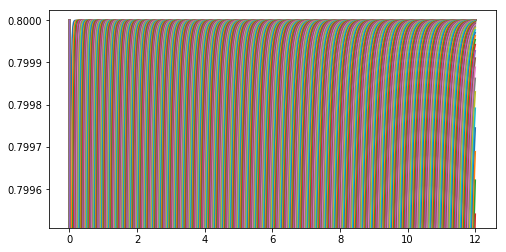

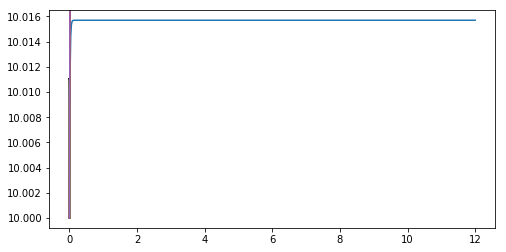

Time of the program's execution: 0.00011396408081054688 seconds 


In [4]:
# Water faucet problem with solvers and preconditioners
"""
WAVE PDE SYSTEM
Solution of convection-diffusion equation using CG and backward Crank Nicholson
PDE: 
IC : 
BC : DIRICHLET

https://fenicsproject.discourse.group/t/aritymismatch-for-crank-nicolson-method-on-mixed-function-space/781/3
"""

from __future__ import print_function
from IPython.display import clear_output
from fenics import *
import matplotlib.pyplot as plt
import numpy as np
import time

# Form compiler options
parameters ["form_compiler"]["optimize"]          = True
parameters ["form_compiler"]["cpp_optimize"]      = True
#parameters["form_compiler"]["representation"] = "quadrature"
parameters ["form_compiler"]["quadrature_degree"] = 2

parameters ["form_compiler"]["cpp_optimize"]      = True
ffc_options = {"optimize": True, \
               "eliminate_zeros": True, \
               "precompute_basis_const": True, \
               "precompute_ip_const": True}

# Define constants
#c     = 1.0
#mu    = 0.001
u1bc1  = 0.8 # alpha0
#u1bc2 = 0.0
u2bc1  = 10.0 # u0
#u2bc2 = 0.0
#rho1   = 1000
#rho2   = 1
f      = 9.81 #g

# Define space discretization properties
xmin   = 0.0
xmax   = 12.0
nx     = 600 # no. of elements 12 to 600
p      = 1  # degree of FEM
mesh   = IntervalMesh (nx, xmin, xmax)
#h      = CellDiameter (mesh)
#hmin   = mesh.hmin ()
deltax = 0.02 # 1 to 0.02m

# Save mesh
File ("waterfaucet_solovers_prec/mesh.xml") << mesh

# Define time discretization properties
T         = 5.0            # final time
Co        = 0.8
dt        = Co*deltax/u2bc1
num_steps = round(T / dt)

# Define funcion spaces
V1      = FiniteElement ('Lagrange', mesh.ufl_cell(), degree=p)
V2      = FiniteElement ('Lagrange', mesh.ufl_cell(), degree=p)
element = MixedElement ([V1, V2])
V       = FunctionSpace (mesh, element)

# Define test and trial functions
v1, v2     = TestFunctions (V)

u          = Function (V, name = "Variables at current step")
u1, u2     = split (u)

du         = TrialFunction (V)

# Define initial condition
class InitialConditions (UserExpression):
    def __init__ (self, **kwargs):
        super (InitialConditions, self).__init__(**kwargs)
    def eval (self, values, x):
        values[0] = u1bc1
        values[1] = u2bc1
    def value_shape (self):
        return (2,)

u_ic       = InitialConditions(degree = p)
u_n        = interpolate (u_ic, V) 
u_n1, u_n2 = split (u_n)

# Define boundary condition
u1_bc1 = Expression ("u1bc1", degree = p, u1bc1 = u1bc1)
#u1_bc2 = Expression ("u1bc2", degree = p, u1bc2 = u1bc2)
u2_bc1 = Expression ("u2bc1", degree = p, u2bc1 = u2bc1)
#u2_bc2 = Expression ("u2bc2", degree = p, u2bc2 = u2bc2)

# Sub domain for Dirichlet boundary condition
def right (x, on_boundary): 
    return x[0] > (1.0 - DOLFIN_EPS)
def left (x, on_boundary): 
    return x[0] < DOLFIN_EPS

bc1 = DirichletBC(V.sub (0), u1_bc1, left)
#bc2 = DirichletBC(V.sub (1), u1_bc2, right)
bc3 = DirichletBC(V.sub (1), u2_bc1, left)
#bc4 = DirichletBC(V.sub (1), u2_bc2, right)
bcs = [bc1, bc3]

# Define expressions used in weak form
k = Expression ("dt", degree = p, dt = dt)
#c = Expression ("c", degree = p, c = c)
f = Expression ("f", degree = p, f = f)

# Define weak form
F = ((u1 - u_n1) / k)*v1*dx + (u2*v1*Dx(u1,0))*dx + (u1*v1*Dx(u2,0))*dx +\
((u2 - u_n2) / k)*v2*dx + (u2*v2*Dx(u2,0))*dx - f*v2*dx

#F = u1*v1*dx - 0.5*k*u2*v1*dx - (u_n1*v1*dx + 0.5*k*u_n2*v1*dx) +\
#u2*v2*dx + 0.5*c**2*k*inner(grad(u1), grad(v2))*dx - (u_n2*v2*dx - 0.5*c**2*k*inner(grad(u_n1), grad(v2))*dx)

# Define Jacobian
dF = derivative (F, u, du)

# Define files
ff1 = File ("waterfaucet_solovers_prec/u1.pvd", "compressed")
ff2 = File ("waterfaucet_solovers_prec/u2.pvd", "compressed")

# Iterative process
t = 0
for n in range (num_steps):

    # Update current time
    t += dt
    #u_D.t = t
    
    # Print progress
    clear_output ()
    print("Iteration :", t/dt, "of", num_steps)
    print("Time      :", t, "s")
    
    # Compute solution
    problem = NonlinearVariationalProblem (F, u, bcs = bcs, J = dF)
    solver  = NonlinearVariationalSolver (problem)
    prm     = solver.parameters
    
    info(prm, True)
    
    prm ['nonlinear_solver'] = 'newton'
    prm ['print_matrix']     = False #True
    prm ['print_rhs']        = False #True
    prm ['symmetric']        = False #True
    
    prm ['newton_solver']['absolute_tolerance']      = 1E-8
    prm ['newton_solver']['convergence_criterion']   = 'incremental' #'residual'
    prm ['newton_solver']['error_on_nonconvergence'] = True
    prm ['newton_solver']['linear_solver']           = 'gmres'       #'ml_amg'
    prm ['newton_solver']['maximum_iterations']      = 25
    prm ['newton_solver']['preconditioner']          = 'ilu'
    prm ['newton_solver']['relative_tolerance']      = 1E-8
    prm ['newton_solver']['relaxation_parameter']    = 1.0
    prm ['newton_solver']['report']                  = True

    prm ['newton_solver']['krylov_solver']['absolute_tolerance']       = 1E-5 #1E-9
    #prm ['newton_solver']['krylov_solver']['divergence_limit']         = 
    prm ['newton_solver']['krylov_solver']['error_on_nonconvergence']  = True
    prm ['newton_solver']['krylov_solver']['maximum_iterations']       = 1000
    prm ['newton_solver']['krylov_solver']["monitor_convergence"]      = True
    prm ['newton_solver']['krylov_solver']["nonzero_initial_guess"]    = True #False
    prm ['newton_solver']['krylov_solver']['relative_tolerance']       = 1E-3
    prm ['newton_solver']['krylov_solver']['report']                   = True
    
    prm ['newton_solver']['lu_solver']['report']    = True
    prm ['newton_solver']['lu_solver']['symmetric'] = True
    prm ['newton_solver']['lu_solver']['verbose']   = True

    PROGRESS = 16
    set_log_level(PROGRESS)
    
    solver.solve()
    
    (u1,u2) = u.split (deepcopy = True)
    
    # Plot solution
    plt.figure (1, figsize = (8, 4))
    #plt.clf()
    plot (u1) #plot alpha from 0.5 to 0.9
    
    plt.figure (2, figsize = (8, 4))
    #plt.clf()
    plot (u2)
    
    # Update previous solution
    u_n.assign (u)
    
    # Save solution
    ff1 << u1
    ff2 << u2

# Hold plot
plt.show ()

# Show time of the program's execution
start_time  = time.time ()
if __name__ == '__main__':
    print("Time of the program's execution: %s seconds " % (time.time () - start_time))

In [5]:
# Water faucet problem with solvers and preconditioners - Assembled *pendiente

